In [208]:
# TODO

# call jax.scipy.sparse.linalg.cg to solve for JVP of gradient of parameters w.r.t hyperparameters
# compute the full gradient of the outer objective w.r.t hyperparameters
# use the hyperparameter gradient + ADAM to optimize w.r.t the hyperparameters

# fine-tune subsequent inner optimizations from precomputed optima
# check that computations of A, B, u, v, and grad_theta are correct

In [209]:
"""
Implicit differentiation of lasso.
==================================
"""

from absl import app
from absl import flags

import jax
import jax.numpy as jnp
from jax.scipy.sparse.linalg import cg as conjugate_gradient
from jax import jvp, grad, jacobian

from jaxopt import BlockCoordinateDescent
from jaxopt import objective
from jaxopt import OptaxSolver
from jaxopt import prox
from jaxopt import ProximalGradient
import optax

from sklearn import datasets
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [210]:
def lasso_objective(params, reg, data):
    lam = jnp.exp(reg)
    X_tr, y_tr = data
    y_pred = jnp.dot(X_tr, params)
    mse = jnp.mean((y_pred - y_tr) ** 2) / 2 
    l1_reg = lam * jnp.sum(jnp.abs(params))
    objective = mse + l1_reg # objective = mean squared error plus L1 regularization
    return objective

def outer_objective(params, data):
    """validation loss """
    X_val, y_val = data
    y_pred = jnp.dot(X_val, params)
    loss_value = jnp.mean((y_pred - y_val) ** 2)
    return loss_value

grad_outer = grad(outer_objective)
grad_inner = grad(lasso_objective)

def solve_inner(theta, data):
    reg = jnp.exp(theta)
    X_tr, y_tr = data
    # use lbfgs? or just optimize directly with scipy.
#     clf = linear_model.Lasso(alpha=float(reg))
#     clf.fit(X_tr, y_tr)
#     loss_value = lasso_objective(clf.coef_, reg, (X_tr, y_tr))
    solver = ProximalGradient(
        fun=objective.least_squares,
        prox=prox.prox_lasso,
        implicit_diff=True,
        maxiter=500)

    # The format is run(init_params, hyperparams_prox, *args, **kwargs)
    # where *args and **kwargs are passed to `fun`.
    w_fit = solver.run(np.zeros(X_tr.shape[1]), reg, (X_tr, y_tr)).params
    loss_value = lasso_objective(w_fit, reg, (X_tr, y_tr))
    return loss_value, w_fit

# hessian-vector product
def hvp(f, primals, tangents):
    return jvp(grad(f), primals, tangents)[1] # use jax.jvp

def solve_lasso(theta_init, data, n_steps=500, step_size=1e-3):
    X_tr, X_val, y_tr, y_val = data
    theta = theta_init
    learning_rate = 1e-2
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    
    for i in range(n_steps):
        # solve inner problem
        _, w_fit = solve_inner(theta, (X_tr, y_tr))
    
        # solve for hyperparameter gradient with conjugate gradient
        v = grad_outer(w_fit, (X_tr, y_tr))
        B = jacobian(grad_inner, argnums=1)(w_fit, theta, (X_tr, y_tr))

        def matvec_A(u):
            return -jvp(lambda w: grad_inner(w, theta, (X_tr, y_tr)), (w_fit,), (u,))[1]

        A = jacobian(grad_inner, argnums=0)(w_fit, theta, (X_tr, y_tr))
        J = jnp.dot(-jnp.linalg.inv(A), B)
        grad_theta_direct = -jnp.dot(v, J)
        
        u = conjugate_gradient(matvec_A, v.T)[0] # compute directly?
        grad_theta = -jnp.dot(u.T, B)
        
        print(f'Iteration {i} of {n_steps} grad_theta, directly computed: {grad_theta_direct}, grad theta efficient: {grad_theta}')
        
        # gradient descent with ADAM
        updates, opt_state = optimizer.update(grad_theta, opt_state)
        theta = optax.apply_updates(theta, updates)
        
        print(f"Iteration {i} of {n_steps}. theta: {theta}, grad_theta: {grad_theta}, validation loss: {outer_objective(w_fit, (X_val, y_val))}")
    
    return theta, w_fit
        

In [204]:
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)
data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)

solve_lasso(1.0, data, n_steps=500, step_size=1e-4)

Iteration 0 of 500 grad_theta, directly computed: 45.103023529052734, grad theta efficient: 45.10622787475586
Iteration 0 of 500. theta: 0.9900000691413879, grad_theta: 45.10622787475586, validation loss: 27122.30859375
Iteration 1 of 500 grad_theta, directly computed: 47.96213150024414, grad theta efficient: 47.963871002197266
Iteration 1 of 500. theta: 0.9799888730049133, grad_theta: 47.963871002197266, validation loss: 27121.97265625
Iteration 2 of 500 grad_theta, directly computed: 50.4366455078125, grad theta efficient: 50.44181823730469
Iteration 2 of 500. theta: 0.969960629940033, grad_theta: 50.44181823730469, validation loss: 27120.59765625
Iteration 3 of 500 grad_theta, directly computed: 52.971343994140625, grad theta efficient: 52.97507095336914
Iteration 3 of 500. theta: 0.9599094986915588, grad_theta: 52.97507095336914, validation loss: 27118.060546875
Iteration 4 of 500 grad_theta, directly computed: 55.32264709472656, grad theta efficient: 55.325645446777344
Iteration 4

Iteration 38 of 500 grad_theta, directly computed: 86.3261947631836, grad theta efficient: 86.32962799072266
Iteration 38 of 500. theta: 0.7780015468597412, grad_theta: 86.32962799072266, validation loss: 27098.490234375
Iteration 39 of 500 grad_theta, directly computed: 86.06692504882812, grad theta efficient: 86.07009887695312
Iteration 39 of 500. theta: 0.7803377509117126, grad_theta: 86.07009887695312, validation loss: 27098.6484375
Iteration 40 of 500 grad_theta, directly computed: 85.7466812133789, grad theta efficient: 85.74890899658203
Iteration 40 of 500. theta: 0.7823348045349121, grad_theta: 85.74890899658203, validation loss: 27098.767578125
Iteration 41 of 500 grad_theta, directly computed: 85.5332260131836, grad theta efficient: 85.53730010986328
Iteration 41 of 500. theta: 0.7840219140052795, grad_theta: 85.53730010986328, validation loss: 27098.748046875
Iteration 42 of 500 grad_theta, directly computed: 85.33202362060547, grad theta efficient: 85.33601379394531
Iterati

Iteration 76 of 500 grad_theta, directly computed: 87.87114715576172, grad theta efficient: 87.8733139038086
Iteration 76 of 500. theta: 0.7591472268104553, grad_theta: 87.8733139038086, validation loss: 27097.328125
Iteration 77 of 500 grad_theta, directly computed: 88.09110260009766, grad theta efficient: 88.09320831298828
Iteration 77 of 500. theta: 0.757457971572876, grad_theta: 88.09320831298828, validation loss: 27096.8828125
Iteration 78 of 500 grad_theta, directly computed: 88.27597045898438, grad theta efficient: 88.27745819091797
Iteration 78 of 500. theta: 0.7557462453842163, grad_theta: 88.27745819091797, validation loss: 27097.0859375
Iteration 79 of 500 grad_theta, directly computed: 88.3948974609375, grad theta efficient: 88.39791107177734
Iteration 79 of 500. theta: 0.7540128827095032, grad_theta: 88.39791107177734, validation loss: 27096.99609375
Iteration 80 of 500 grad_theta, directly computed: 93.4599609375, grad theta efficient: 93.46356201171875
Iteration 80 of 50

Iteration 114 of 500 grad_theta, directly computed: 90.37293243408203, grad theta efficient: 90.37542724609375
Iteration 114 of 500. theta: 0.7348902225494385, grad_theta: 90.37542724609375, validation loss: 27095.5
Iteration 115 of 500 grad_theta, directly computed: -2512.0439453125, grad theta efficient: -2512.091064453125
Iteration 115 of 500. theta: 0.7387453317642212, grad_theta: -2512.091064453125, validation loss: 27093.21484375
Iteration 116 of 500 grad_theta, directly computed: 90.26013946533203, grad theta efficient: 90.26353454589844
Iteration 116 of 500. theta: 0.7420568466186523, grad_theta: 90.26353454589844, validation loss: 27096.123046875
Iteration 117 of 500 grad_theta, directly computed: 89.87210845947266, grad theta efficient: 89.87496948242188
Iteration 117 of 500. theta: 0.7448768615722656, grad_theta: 89.87496948242188, validation loss: 27095.875
Iteration 118 of 500 grad_theta, directly computed: 89.53694152832031, grad theta efficient: 89.53898620605469
Iterati

Iteration 151 of 500 grad_theta, directly computed: -2484.74609375, grad theta efficient: -2484.792724609375
Iteration 151 of 500. theta: 0.7285093665122986, grad_theta: -2484.792724609375, validation loss: 27095.1875
Iteration 152 of 500 grad_theta, directly computed: 89.79107666015625, grad theta efficient: 89.79270935058594
Iteration 152 of 500. theta: 0.7314656972885132, grad_theta: 89.79270935058594, validation loss: 27095.453125
Iteration 153 of 500 grad_theta, directly computed: 90.54312896728516, grad theta efficient: 90.54541015625
Iteration 153 of 500. theta: 0.7339532971382141, grad_theta: 90.54541015625, validation loss: 27094.84765625
Iteration 154 of 500 grad_theta, directly computed: 90.5552749633789, grad theta efficient: 90.55728149414062
Iteration 154 of 500. theta: 0.7360169291496277, grad_theta: 90.55728149414062, validation loss: 27095.482421875
Iteration 155 of 500 grad_theta, directly computed: 90.178955078125, grad theta efficient: 90.1804428100586
Iteration 155

Iteration 189 of 500 grad_theta, directly computed: -2543.622314453125, grad theta efficient: -2543.66796875
Iteration 189 of 500. theta: 0.7496392726898193, grad_theta: -2543.66796875, validation loss: 27088.6875
Iteration 190 of 500 grad_theta, directly computed: 89.06258392333984, grad theta efficient: 89.06683349609375
Iteration 190 of 500. theta: 0.7538269758224487, grad_theta: 89.06683349609375, validation loss: 27096.607421875
Iteration 191 of 500 grad_theta, directly computed: 88.41114807128906, grad theta efficient: 88.4134292602539
Iteration 191 of 500. theta: 0.7574356198310852, grad_theta: 88.4134292602539, validation loss: 27096.990234375
Iteration 192 of 500 grad_theta, directly computed: 88.2834243774414, grad theta efficient: 88.28633880615234
Iteration 192 of 500. theta: 0.7605213522911072, grad_theta: 88.28633880615234, validation loss: 27097.10546875
Iteration 193 of 500 grad_theta, directly computed: 88.09130859375, grad theta efficient: 88.09423065185547
Iteration 

Iteration 226 of 500 grad_theta, directly computed: 88.19538879394531, grad theta efficient: 88.19851684570312
Iteration 226 of 500. theta: 0.7616510987281799, grad_theta: 88.19851684570312, validation loss: 27097.154296875
Iteration 227 of 500 grad_theta, directly computed: 77.353759765625, grad theta efficient: 77.35603332519531
Iteration 227 of 500. theta: 0.7635049223899841, grad_theta: 77.35603332519531, validation loss: 27108.560546875
Iteration 228 of 500 grad_theta, directly computed: 86.45645904541016, grad theta efficient: 86.45893859863281
Iteration 228 of 500. theta: 0.7650056481361389, grad_theta: 86.45893859863281, validation loss: 27097.953125
Iteration 229 of 500 grad_theta, directly computed: 88.25587463378906, grad theta efficient: 88.25857543945312
Iteration 229 of 500. theta: 0.7661838531494141, grad_theta: 88.25857543945312, validation loss: 27110.453125
Iteration 230 of 500 grad_theta, directly computed: 87.3587646484375, grad theta efficient: 87.36153411865234
It

Iteration 263 of 500 grad_theta, directly computed: 88.63312530517578, grad theta efficient: 88.63557434082031
Iteration 263 of 500. theta: 0.7651098966598511, grad_theta: 88.63557434082031, validation loss: 27098.0625
Iteration 264 of 500 grad_theta, directly computed: 80.84577941894531, grad theta efficient: 80.84831237792969
Iteration 264 of 500. theta: 0.7702831625938416, grad_theta: 80.84831237792969, validation loss: 27092.3359375
Iteration 265 of 500 grad_theta, directly computed: 86.90869903564453, grad theta efficient: 86.91233825683594
Iteration 265 of 500. theta: 0.7747817635536194, grad_theta: 86.91233825683594, validation loss: 27098.2421875
Iteration 266 of 500 grad_theta, directly computed: 83.38412475585938, grad theta efficient: 83.38734436035156
Iteration 266 of 500. theta: 0.7786783576011658, grad_theta: 83.38734436035156, validation loss: 27095.04296875
Iteration 267 of 500 grad_theta, directly computed: 85.94884490966797, grad theta efficient: 85.95081329345703
Ite

Iteration 300 of 500 grad_theta, directly computed: 86.72247314453125, grad theta efficient: 86.72506713867188
Iteration 300 of 500. theta: 0.770453929901123, grad_theta: 86.72506713867188, validation loss: 27097.5859375
Iteration 301 of 500 grad_theta, directly computed: 86.87805938720703, grad theta efficient: 86.8800048828125
Iteration 301 of 500. theta: 0.7688331604003906, grad_theta: 86.8800048828125, validation loss: 27097.90625
Iteration 302 of 500 grad_theta, directly computed: 82.6972885131836, grad theta efficient: 82.70115661621094
Iteration 302 of 500. theta: 0.767200767993927, grad_theta: 82.70115661621094, validation loss: 27101.345703125
Iteration 303 of 500 grad_theta, directly computed: 87.23017883300781, grad theta efficient: 87.23466491699219
Iteration 303 of 500. theta: 0.7655482888221741, grad_theta: 87.23466491699219, validation loss: 27097.572265625
Iteration 304 of 500 grad_theta, directly computed: 87.40234375, grad theta efficient: 87.40690612792969
Iteration 

Iteration 337 of 500 grad_theta, directly computed: 89.81517028808594, grad theta efficient: 89.8189697265625
Iteration 337 of 500. theta: 0.7416858673095703, grad_theta: 89.8189697265625, validation loss: 27096.091796875
Iteration 338 of 500 grad_theta, directly computed: 89.8694076538086, grad theta efficient: 89.87126159667969
Iteration 338 of 500. theta: 0.7413378953933716, grad_theta: 89.87126159667969, validation loss: 27095.99609375
Iteration 339 of 500 grad_theta, directly computed: 89.89835357666016, grad theta efficient: 89.90223693847656
Iteration 339 of 500. theta: 0.7408353686332703, grad_theta: 89.90223693847656, validation loss: 27095.935546875
Iteration 340 of 500 grad_theta, directly computed: 93.80904388427734, grad theta efficient: 93.81195068359375
Iteration 340 of 500. theta: 0.7401849627494812, grad_theta: 93.81195068359375, validation loss: 27093.46875
Iteration 341 of 500 grad_theta, directly computed: 90.11506652832031, grad theta efficient: 90.11678314208984
I

Iteration 374 of 500 grad_theta, directly computed: 90.0235824584961, grad theta efficient: 90.02629089355469
Iteration 374 of 500. theta: 0.738251268863678, grad_theta: 90.02629089355469, validation loss: 27095.916015625
Iteration 375 of 500 grad_theta, directly computed: 90.10839080810547, grad theta efficient: 90.10995483398438
Iteration 375 of 500. theta: 0.7366733551025391, grad_theta: 90.10995483398438, validation loss: 27095.763671875
Iteration 376 of 500 grad_theta, directly computed: 90.30641174316406, grad theta efficient: 90.30963897705078
Iteration 376 of 500. theta: 0.7350589036941528, grad_theta: 90.30963897705078, validation loss: 27095.556640625
Iteration 377 of 500 grad_theta, directly computed: 90.4056625366211, grad theta efficient: 90.4076919555664
Iteration 377 of 500. theta: 0.7334110140800476, grad_theta: 90.4076919555664, validation loss: 27095.59765625
Iteration 378 of 500 grad_theta, directly computed: 90.73426818847656, grad theta efficient: 90.73768615722656

Iteration 412 of 500 grad_theta, directly computed: 87.77494812011719, grad theta efficient: 87.77679443359375
Iteration 412 of 500. theta: 0.7603612542152405, grad_theta: 87.77679443359375, validation loss: 27097.322265625
Iteration 413 of 500 grad_theta, directly computed: 92.06961822509766, grad theta efficient: 92.0728530883789
Iteration 413 of 500. theta: 0.76022869348526, grad_theta: 92.0728530883789, validation loss: 27094.685546875
Iteration 414 of 500 grad_theta, directly computed: 87.86959838867188, grad theta efficient: 87.871826171875
Iteration 414 of 500. theta: 0.7599273324012756, grad_theta: 87.871826171875, validation loss: 27102.837890625
Iteration 415 of 500 grad_theta, directly computed: 87.12735748291016, grad theta efficient: 87.12982177734375
Iteration 415 of 500. theta: 0.7594751715660095, grad_theta: 87.12982177734375, validation loss: 27098.388671875
Iteration 416 of 500 grad_theta, directly computed: 88.04894256591797, grad theta efficient: 88.05194854736328
I

Iteration 449 of 500 grad_theta, directly computed: 91.31841278076172, grad theta efficient: 91.3216552734375
Iteration 449 of 500. theta: 0.7591211795806885, grad_theta: 91.3216552734375, validation loss: 27088.20703125
Iteration 450 of 500 grad_theta, directly computed: 88.10486602783203, grad theta efficient: 88.10823059082031
Iteration 450 of 500. theta: 0.7628345489501953, grad_theta: 88.10823059082031, validation loss: 27097.193359375
Iteration 451 of 500 grad_theta, directly computed: 87.61528015136719, grad theta efficient: 87.61656188964844
Iteration 451 of 500. theta: 0.7660041451454163, grad_theta: 87.61656188964844, validation loss: 27097.478515625
Iteration 452 of 500 grad_theta, directly computed: 86.80194854736328, grad theta efficient: 86.8028335571289
Iteration 452 of 500. theta: 0.7686851024627686, grad_theta: 86.8028335571289, validation loss: 27097.32421875
Iteration 453 of 500 grad_theta, directly computed: 86.86719512939453, grad theta efficient: 86.86943054199219

Iteration 486 of 500 grad_theta, directly computed: 89.42216491699219, grad theta efficient: 89.42601013183594
Iteration 486 of 500. theta: 0.7469021677970886, grad_theta: 89.42601013183594, validation loss: 27096.208984375
Iteration 487 of 500 grad_theta, directly computed: 90.6244125366211, grad theta efficient: 90.62706756591797
Iteration 487 of 500. theta: 0.7451515793800354, grad_theta: 90.62706756591797, validation loss: 27095.72265625
Iteration 488 of 500 grad_theta, directly computed: 89.48892974853516, grad theta efficient: 89.49139404296875
Iteration 488 of 500. theta: 0.7433845400810242, grad_theta: 89.49139404296875, validation loss: 27096.109375
Iteration 489 of 500 grad_theta, directly computed: 89.6629409790039, grad theta efficient: 89.66600799560547
Iteration 489 of 500. theta: 0.7416021227836609, grad_theta: 89.66600799560547, validation loss: 27096.037109375
Iteration 490 of 500 grad_theta, directly computed: 89.81407165527344, grad theta efficient: 89.81672668457031

(Array(0.728526, dtype=float32),
 Array([ -0.        ,  -0.        ,  62.65658   ,  58.21589   ,
         -0.11164641,  -0.        , -22.910603  ,  -0.        ,
         47.94851   ,   0.        ], dtype=float32))

In [215]:
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)
data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
X_tr, X_val, y_tr, y_val = data
print(X_tr.shape)
print(y_tr.shape)

(296, 10)
(296,)


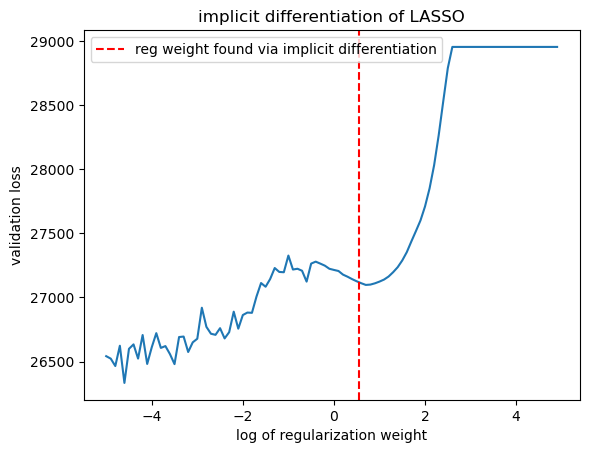

In [211]:
# load data
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)
data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
X_tr, X_val, y_tr, y_val = data

results = []
for theta in jnp.arange(-5, 5, 0.1):
    _, w = solve_inner(theta, (X_tr, y_tr))
    val_loss = outer_objective(w, (X_val, y_val))
    results.append([theta, val_loss])

thetas = np.array(results)[:, 0]
loss = np.array(results)[:, 1]
plt.plot(thetas, loss)
plt.axvline(x=0.728526, color='red', linestyle='--', label='reg weight found via implicit differentiation')
plt.xlabel('log of regularization weight')            # Label for x-axis
plt.ylabel('validation loss')            # Label for y-axis
plt.title('implicit differentiation of LASSO')  # Title of the plot
plt.legend()

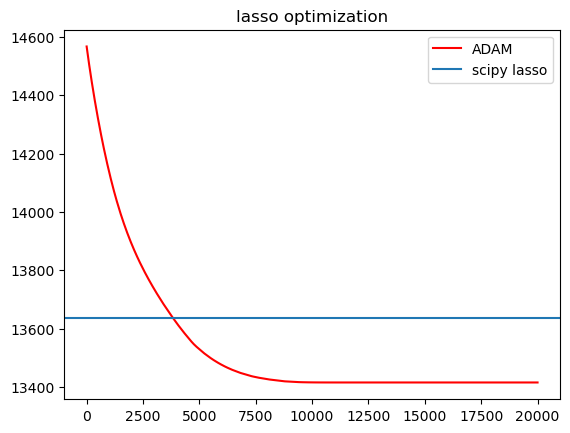

In [201]:
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)

data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
X_tr, X_test, y_tr, y_test = data


solver = OptaxSolver(opt=optax.adam(1e-2), fun=lasso_objective) # use gradient descent with ADAM
w = jnp.zeros(X_tr.shape[1])
reg = 0.1
state = solver.init_state(w, reg=reg, data=(X_tr, y_tr))

loss_vals = []
for i in range(20000):
    w, state = solver.update(params=w, state=state, reg=reg, data=(X_tr, y_tr))
    loss_vals.append([i, state.value])
loss_vals = np.array(loss_vals)

clf = linear_model.Lasso(alpha=reg)
clf.fit(X_tr, y_tr)
final_loss = lasso_objective(clf.coef_, reg, (X_tr, y_tr))

plt.title('lasso optimization')
plt.plot(loss_vals[:, 0], loss_vals[:, 1], color='red', label='ADAM')
plt.axhline(y=final_loss, label='scipy lasso')
plt.legend()

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.90000004
1.0
1.1
1.2
1.3000001
1.4
1.5
1.6
1.7
1.8000001
1.9


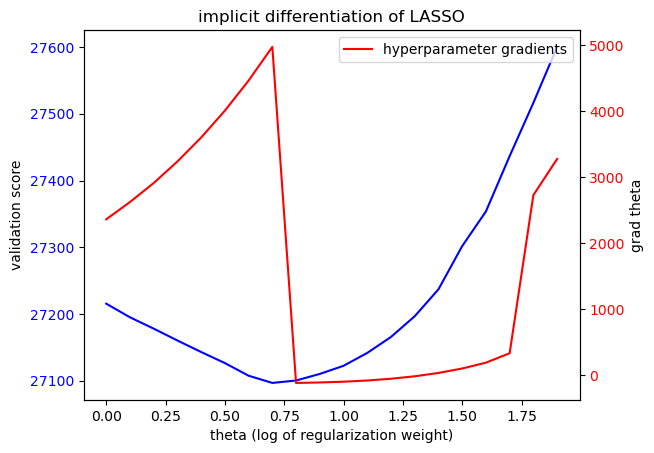

In [226]:
def hyperparameter_gradient(theta, data):
    X_tr, X_val, y_tr, y_val = data
    _, w_fit = solve_inner(theta, (X_tr, y_tr))
    
    # solve for hyperparameter gradient with conjugate gradient
    v = grad_outer(w_fit, (X_val, y_val))
    B = jacobian(grad_inner, argnums=1)(w_fit, theta, (X_tr, y_tr))
    A = -jacobian(grad_inner, argnums=0)(w_fit, theta, (X_tr, y_tr))
#     print(B)
    J = jnp.dot(jnp.linalg.inv(A), B)
    grad_theta_direct = jnp.dot(v.T, J)
#     def matvec_A(u):
#         return jvp(lambda w: grad_inner(w, theta, (X_tr, y_tr)), (w_fit,), (u,))[1]

#     A = jacobian(grad_inner, argnums=0)(w_fit, theta, (X_tr, y_tr))
    
#     u = conjugate_gradient(matvec_A, v.T)[0] # compute directly?
#     grad_theta = -jnp.dot(u.T, B)

    return grad_theta_direct

# load data
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)
data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
X_tr, X_val, y_tr, y_val = data

hyperparameter_gradient(0.0, data)

results = []
for theta in jnp.arange(0, 2, 0.1):
    print(theta)
    _, w = solve_inner(theta, (X_tr, y_tr))
    val_loss = outer_objective(w, (X_val, y_val))
    grad_theta = hyperparameter_gradient(theta, data)
    results.append([theta, val_loss, grad_theta])

thetas = np.array(results)[:, 0]
loss = np.array(results)[:, 1]
grads = np.array(results)[:, 2]

fig, ax1 = plt.subplots()
ax1.plot(thetas, loss, color='blue', label='validation scores')
ax1.set_xlabel('theta (log of regularization weight)')
ax1.set_ylabel('validation score')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(thetas, grads, color='red', label='hyperparameter gradients')
ax2.set_xlabel('theta (log of regularization weight)')
ax2.set_ylabel('grad theta')
ax2.tick_params(axis='y', labelcolor='red')

#plt.plot(thetas, loss, label='validation loss for theta')
           # Label for y-axis
plt.title('implicit differentiation of LASSO')  # Title of the plot
plt.legend()